In [46]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt
import os
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy import signal
from scipy.interpolate import interp1d
import scipy as sp

In [59]:
""" hyperparameters """
# ambient temp
Tamb = 25.

# model dimension
n = 7

# data scaling factor
scale = 1.0

# discretization interval
tau = 1.0

# rk4 solver steps size
step_size = 2.0

# learning rate
lr = 1e-2

# early stop for early iterations
loss_threshold = 2

# learning schedule
horizon_initial = 10
horizon_step = 5
max_iter_inner = 1000

# regularization
l1_reg = 0
l2_reg = 0
A_sum_reg = 0

In [60]:
def resample(s: pd.Series) -> pd.Series:
    """
    Resample a pandas Series with unevenly spaced time indices to be even.

    Parameters
    ----------
    s : pd.Series
        The input signal as a pandas Series. The Series index should be time.

    Returns
    -------
    tuple
        The resampled signal as a pandas Series, resampling period as a float,
        and new timebase as a numpy array.
    """
    assert isinstance(s, pd.Series)
    
    # Resampling parameters - change these to suit your data
    resampling_period = s.index.to_series().diff().mean()
    
    # Interpolate to a new time base (resample)
    f_interp = interp1d(s.index, s.values, kind='linear',
                        fill_value='extrapolate')
    new_timebase = np.arange(s.index.min(), s.index.max(), resampling_period)
    if new_timebase[-1] < s.index.max():
        new_timebase = np.append(new_timebase, s.index.max())
    s_interpolated = pd.Series(f_interp(new_timebase), index=new_timebase)
    
    return s_interpolated, resampling_period, new_timebase


def lowpass_filter_series(s: pd.Series, cutoff_freq: float, 
                          butterworth_order: int) -> pd.Series:
    """
    Apply a lowpass Butterworth filter to a pandas Series with uneven time
    indices.

    Parameters
    ----------
    s : pd.Series
        The input signal as a pandas Series. The Series index should be time.
    cutoff_freq : float
        The cutoff frequency for the lowpass filter.
    butterworth_order : int
        The order of the Butterworth filter.

    Returns
    -------
    pd.Series
        The filtered signal as a pandas Series.
    """
    s_interpolated, resampling_period, new_timebase = resample(s)

    # Create the low-pass filter
    nyquist_rate = 0.5 / resampling_period
    normalized_cutoff_freq = cutoff_freq / nyquist_rate
    b, a = signal.butter(butterworth_order, normalized_cutoff_freq, 
                         btype='low')
    
    # Apply the low-pass filter
    filtered_signal = signal.filtfilt(b, a, s_interpolated)
    s_filtered_interpolated = pd.Series(filtered_signal, 
                                        index=new_timebase)

    # Interpolate back to the original timebase
    f_interp_back = interp1d(s_filtered_interpolated.index, 
                             s_filtered_interpolated.values, kind='linear')
    s_filtered = pd.Series(f_interp_back(s.index), index=s.index)

    return s_filtered


def z_transform_series(s: pd.Series, a: list, b: list) -> pd.Series:
    """
    Apply a Z-transform to a pandas Series with unevenly spaced time indices.

    Parameters
    ----------
    s : pd.Series
        The input signal as a pandas Series. The Series index should be time.
    a : list
        The denominator coefficient vector in a 1-D sequence (filter's recursive part).
    b : list
        The numerator coefficient vector in a 1-D sequence (filter's non-recursive part).

    Returns
    -------
    pd.Series
        The transformed signal as a pandas Series.
    """
    s_interpolated, _, new_timebase = resample(s)

    # Apply the Z-transform
    transformed_signal = signal.lfilter(b, a, s_interpolated)
    s_transformed_interpolated = pd.Series(transformed_signal, 
                                           index=new_timebase)

    # Interpolate back to the original timebase
    f_interp_back = interp1d(s_transformed_interpolated.index, 
                             s_transformed_interpolated.values, kind='linear')
    s_transformed = pd.Series(f_interp_back(s.index), index=s.index)

    return s_transformed

In [61]:
dfs = {
    'temperature': pd.DataFrame(index=np.arange(4600), dtype=float),
    'seconds': pd.DataFrame(index=np.arange(4600), dtype=float),
    'heat': pd.DataFrame(index=np.arange(4600), dtype=float)
}

for filename in os.listdir('../logs/'):
    df_read = pd.read_csv(f'../logs/{filename}', header=None)[0].values
    if len(df_read) > 4600:
        continue
    df_read = np.pad(
        df_read, ((0, 4600-len(df_read)),), 'constant', constant_values=np.nan
    )

    keys = filename.split('.')[0].split('_')
    datatype = keys[1]
    timestamp = keys[-1]

    if datatype not in dfs.keys():
        continue
    dfs[datatype][timestamp] = df_read

dfs = {
    key: df.set_index([pd.MultiIndex.from_product([[key], df.index])]) 
    for key, df in dfs.items()
}

combined = pd.concat(dfs.values(), axis=0)
null_heats = [
    colname for colname in combined.columns 
    if np.isnan(combined.loc['heat', colname].iloc[0])
]
combined.drop(columns=null_heats, inplace=True)
null_heats = [
    colname for colname in combined.columns 
    if int(np.round(6*np.max(combined[colname].loc['heat']))) == 6 
    and (combined[colname].loc['seconds'] > 0).sum() < 600
]
combined.drop(columns=null_heats, inplace=True)
combined.rename(
    lambda x: int(np.round(6*np.max(combined[x].loc['heat']))), 
    axis=1,
    inplace=True
)

In [62]:
indices = [2, 4, 5, 6]

turnon = {}
for i in indices:
    turnon[i] = np.argmax(combined.loc['heat'][i])

startidx = {}
for i in indices:
    startidx[i] = np.argmin(combined.loc['temperature'][i].iloc[:turnon[i]+10])

# hit10 = {}
# for i in indices:
#     temp_curve = combined.loc['temperature'][i]
#     wherelarge = temp_curve[temp_curve > 10]
#     if len(wherelarge) > 0:
#         hit10[i] = np.argmax(temp_curve > 10)
#     else:
#         hit10[i] = -1

turnoff = {}
for i in indices:
    turnoff[i] = np.argmin(combined.loc['heat'][i].iloc[turnon[i]:]) + turnon[i]

endidx = {}
for i in indices:
    endidx[i] = np.argmax(np.isnan(combined.loc['heat'][i]))

temps_series = {}
for i in indices:
    secs = combined.loc['seconds'][i].iloc[turnon[i]:endidx[i]].values
    secs -= secs[0]
    temps = combined.loc['temperature'][i].iloc[turnon[i]:endidx[i]].values
    temps_series[i] = pd.Series(temps, index=secs)

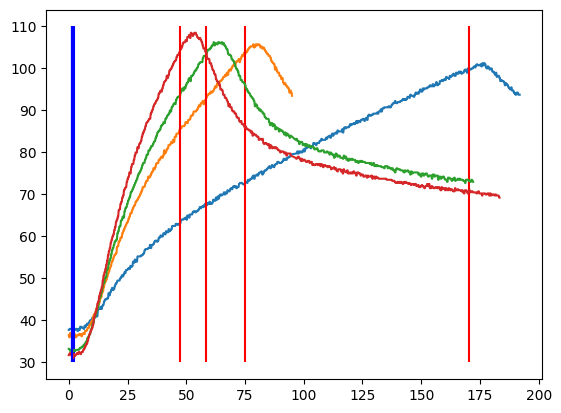

In [63]:
for i in indices:
    # secs = combined.loc['seconds'][i].iloc[turnon[i]:turnoff[i]].values
    secs = combined.loc['seconds'][i].values
    secs -= secs[0]
    plt.plot(
        secs,
        # combined.loc['temperature'][i].iloc[turnon[i]:turnoff[i]].values,
        combined.loc['temperature'][i].values,
        label=str(i)
    )
    start = combined.loc['seconds'][i].iloc[turnon[i]]
    stop = combined.loc['seconds'][i].iloc[turnoff[i]]
    plt.vlines(start, 30, 110, label="start", color="blue")
    plt.vlines(stop, 30, 110, label="end", color="red")

In [64]:
# preprocess data
data = {}
for i in indices:
    # time
    secs = combined.loc['seconds'][i].values
    secs -= secs[0]
    start = combined.loc['seconds'][i].iloc[turnon[i]]
    stop = combined.loc['seconds'][i].iloc[turnoff[i]]

    # control
    heat_level = i / 6.0
    u = np.array([heat_level if s >= start and s <= stop else 0.0 for s in secs])

    # temp
    T = combined.loc['temperature'][i].values

    idx = np.isfinite(secs)
    data[i] = {
        "t": secs[idx],
        "u": u[idx],
        "T": T[idx],
        "P": np.zeros(len(T[idx])),
        "h": np.zeros(len(u[idx]))
    }

    print(i, len(secs[idx]))

# add constant ambient temp
# data[0] = {
#     "t": data[2]["t"],
#     "u": 0. * data[2]["t"],
#     "T": Tamb * np.ones(len(data[2]["t"])),
# }

2 1000
4 500
5 897
6 956


In [65]:
data_flow = {}

id = 10
for filename in os.listdir('../logs/'):
    if filename[-3:] == 'csv':
        np_read = np.loadtxt(f'../logs/{filename}', delimiter=',', dtype=float)
        np_read[:, 0] -= np_read[0, 0]

        pump_on = np.argmax(np_read[:, 4] > 0)

        if pump_on > 0:
            pump_off = len(np_read) - np.argmax(np.flip(np_read[pump_on:, 4]) > 0)

            no_flow_1 = np_read[:pump_on]

            flow = np_read[pump_on:pump_off].copy()
            flow[:, 0] -= flow[0, 0]

            no_flow_2 = np_read[pump_off:].copy()
            no_flow_2[:, 0] -= no_flow_2[0, 0]

            data[id] = {
                "t": no_flow_1[:, 0],
                "u": no_flow_1[:, 3],
                "T": no_flow_1[:, 1],
                "P": no_flow_1[:, 2],
                "h": no_flow_1[:, 4]
            }

            data_flow[id] = {
                "t": flow[:, 0],
                "u": flow[:, 3],
                "T": flow[:, 1],
                "P": flow[:, 2],
                "h": flow[:, 4]
            }

            data[id + 100] = {
                "t": no_flow_2[:, 0],
                "u": no_flow_2[:, 3],
                "T": no_flow_2[:, 1],
                "P": no_flow_2[:, 2],
                "h": no_flow_2[:, 4]
            }

            print(id, len(no_flow_1))
            print(id + 100, len(no_flow_2))
        else:
            data[id] = {
                "t": np_read[:, 0],
                "u": np_read[:, 3],
                "T": np_read[:, 1],
                "P": np_read[:, 2],
                "h": np_read[:, 4]
            }

            print(id, len(np_read))
        id += 1

10 7600
11 7056
12 6370
112 3100
13 9109
113 1742
14 24026
114 189
15 6100
115 502
16 9686
17 8619
117 4239
18 14132
118 1107
19 12889
119 4421


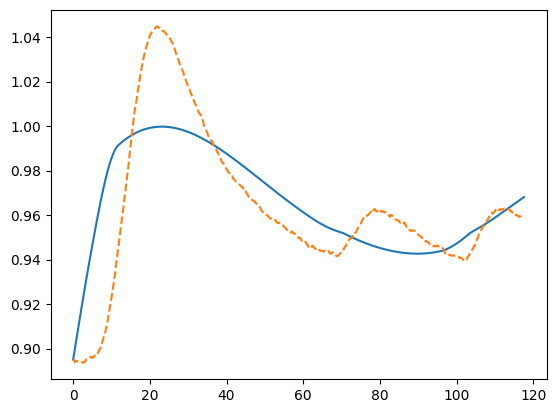

array([[1.76947181e+00],
       [4.59415034e-05],
       [1.35572461e-05],
       [1.47924360e-05],
       [1.86064650e-05]])

# dynamics fitting - torchdiffeq

In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from torchdiffeq import odeint
# from torchdiffeq import odeint_adjoint as odeint


class LinearDynamics(nn.Module):
    """ Linear dynamics: x' = Ax + Bu """
    def __init__(self, n, m=1, Tamb=30.0):
        super().__init__()
        self.n = n
        self.m = m
        self.Tamb = Tamb

        self.A = nn.Parameter(torch.zeros(n, n))
        self.B = nn.Parameter(torch.randn(n, 1))

    def c(self):
        return -self.Tamb * self.A.sum(axis=1)

    def forward(self, t, x, u=None):
        return F.linear(x, self.A, bias=self.c()) + F.linear(u, self.B)
    

class CustomLinearDynamics(nn.Module):
    """ Custom linear dynamics """
    def __init__(self, Tamb=30.0):
        super().__init__()
        self.n = 4
        self.Tamb = Tamb

        self.A12 = nn.Parameter(torch.tensor(0.0))
        self.A13 = nn.Parameter(torch.tensor(0.0))
        self.A14 = nn.Parameter(torch.tensor(0.0))
        self.A21 = nn.Parameter(torch.tensor(0.0))
        self.A31 = nn.Parameter(torch.tensor(0.0))
        self.A44 = nn.Parameter(torch.tensor(0.0))
        self.C4 = nn.Parameter(torch.tensor(0.0))
        self.B4 = nn.Parameter(torch.tensor(1.0))

    def forward(self, t, x, u=None):
        T_boiler, T_water, T_air, P = x.unbind(-1)  # using unbind instead of slicing

        dT_boiler_dt = -(self.A12 + self.A13) * T_boiler + self.A12 * T_water + self.A13 * T_air + self.A14 * P
        dT_water_dt = self.A21 * T_boiler - self.A21 * T_water
        dT_air_dt = self.A31 * T_boiler - (self.A31 + self.C4) * T_air + self.Tamb * self.C4
        dP_dt = self.A44 * P + self.B4 * u.squeeze(-1)  # unsqueezing u

        return torch.stack([dT_boiler_dt, dT_water_dt, dT_air_dt, dP_dt], dim=-1)


class LookupLinearInterpolator:
    """
        Interpolator requires init_interpolation to be called
        before querying
    """
    def __init__(self):
        # input sequence to be interpolated
        self.t_seq = None
        self.u_seq = None
        self.length = 0

    def init_interpolation(self, t_seq, u_seq):
        """ t is 1-D, u has shape (batch_size, time, dim) """
        assert t_seq.shape[0] == u_seq.shape[1]
        self.t_seq = t_seq.detach().cpu().numpy()
        self.u_seq = Variable(u_seq).to(u_seq.device)
        self.length = t_seq.shape[0]

    def __call__(self, t):
        """ return interpolation of loaded input sequence """
        idx_right = np.searchsorted(self.t_seq, t.item(), side='left')
        idx_left = idx_right - 1

        # if extend past sequence, just return last element
        if idx_right == self.length:
            return self.u_seq[:, -1]

        # if hit starting time, return first element
        if idx_right == 0:
            return self.u_seq[:, 0]

        # linear interpolation
        t_left = self.t_seq[idx_left]
        u_left = self.u_seq[:,idx_left]

        u_diff = self.u_seq[:,idx_right] - u_left
        t_diff = self.t_seq[idx_right] - t_left
        slope = u_diff / t_diff

        return slope*(t - t_left) + u_left

class DynamicsWrapper(nn.Module):
    """ nn.Module wrapper to ensure that odeint_adjoint works correctly """
    def __init__(self, dynamics, input_interpolator):
        super().__init__()
        self.n = dynamics.n
        self.dynamics = dynamics
        self.input_interpolator = input_interpolator

    def forward(self, t, x):        
        return self.dynamics(t, x, self.input_interpolator(t))
    

class DynamicalSystem(nn.Module):
    def __init__(self, dynamics, interpolator, step_size):
        super().__init__()
        self.n = dynamics.n
        self.dynamics = dynamics
        self.interpolator = interpolator
        self.step_size = step_size

    def forward(self, t, u, x0):
        self.dynamics.input_interpolator.init_interpolation(t[0,:], u)
        return odeint(self.dynamics, x0, t[0, :], method="rk4", options=dict(step_size=self.step_size)).permute(1,0,2)

In [55]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print("Using device: ", device)

Using device:  cpu


In [56]:
dynamics = LinearDynamics(n, Tamb=Tamb/scale)
interp = LookupLinearInterpolator()
wrapped_dynamics = DynamicsWrapper(dynamics, interp)
model = DynamicalSystem(wrapped_dynamics, interp, step_size)

In [57]:
# downsample and scale data
data_interp = {}
for i in data.keys():
    t, u, T = data[i]["t"], data[i]["u"], data[i]["T"]

    t_interp = np.arange(t[0], t[-1], tau)
    T_interp = np.interp(t_interp, t, T)
    u_interp = np.interp(t_interp, t, u)

    data_interp[i] = {
        "t": t_interp,
        "u": u_interp,
        "T": T_interp / scale,
    }

    print(i, T_interp.shape)

# convert data to torch tensor, and scale data
def convert(d, device):
    data_torch = {}
    for i in d.keys():
        data_torch[i] = {
            "t": torch.tensor(d[i]["t"]).reshape(1, -1).float().to(device),
            "u": torch.tensor(d[i]["u"]).reshape(1, -1, 1).float().to(device),
            "T": torch.tensor(d[i]["T"]).reshape(1, -1, 1).float().to(device),
        }
        data_torch[i]["x0"] = data_torch[i]["T"][0,0,0].repeat(data_torch[i]["u"].shape[0], n).to(device)
    return data_torch

data_torch = convert(data_interp, device)

2 (192,)
4 (96,)
5 (173,)
6 (184,)
10 (127,)
11 (118,)
12 (107,)
112 (52,)
13 (152,)
113 (30,)
14 (401,)
114 (4,)
15 (102,)
115 (9,)
16 (162,)
17 (144,)
117 (71,)
18 (236,)
118 (19,)
19 (215,)
119 (74,)


In [58]:
max_length = np.max([data_torch[key]["t"].shape[1] for key in data_torch.keys()])

losses = []
# gradually increase fitting horizon
for H in np.arange(horizon_initial, max_length + horizon_step, horizon_step):
    print("===== Horizon %d =====" % H)

    # inner loop
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for itr in range(1, max_iter_inner + 1):
        optimizer.zero_grad()

        # fitting loss
        loss = 0.0
        for i in data_torch.keys():
            T_pred = model(data_torch[i]["t"][:,:H], data_torch[i]["u"][:,:H], data_torch[i]["x0"])
            loss += (T_pred[0,:,0] - data_torch[i]["T"][0,:H,0]).pow(2).mean()

        # regularization
        if l1_reg > 0:
            loss += l1_reg * model.dynamics.dynamics.A.abs().sum()
            loss += l1_reg * model.dynamics.dynamics.B.abs().sum()

        if l2_reg > 0:
            loss += l2_reg * model.dynamics.dynamics.A.pow(2).sum()
            loss += l2_reg * model.dynamics.dynamics.B.pow(2).sum()

        if A_sum_reg > 0:
            loss += A_sum_reg * model.dynamics.dynamics.A.sum()

        loss.backward()
        optimizer.step()
        itr_loss = loss.item()
        losses.append(itr_loss)

        if itr % 10 == 0:
            print(itr, itr_loss)

        # early stop except when fitting with all data
        if itr_loss < loss_threshold and H < max_length:
            break

===== Horizon 10 =====
10 76.3490219116211
20 61.178611755371094
30 61.0306396484375
40 59.07508087158203
50 57.802955627441406
60 56.03185272216797
70 54.14360809326172
80 52.42056655883789
90 51.64040756225586
100 51.558502197265625
110 51.479713439941406
120 51.3597297668457
130 51.274574279785156
140 51.1922721862793
150 51.10615921020508
160 51.02044677734375
170 50.933837890625
180 50.84648895263672
190 50.75813674926758
200 50.66862487792969
210 50.577720642089844
220 50.48524856567383
230 50.391029357910156
240 50.294715881347656
250 50.19615173339844
260 50.09491729736328
270 49.990814208984375
280 49.88362121582031
290 49.77314376831055
300 49.658935546875
310 49.541358947753906
320 49.41984939575195
330 49.29460144042969
340 49.16558837890625
350 49.03297805786133
360 48.896461486816406
370 48.756736755371094
380 48.61384582519531
390 48.53410339355469
400 48.47865295410156
410 48.31224822998047
420 48.145286560058594
430 48.012779235839844
440 47.89335632324219
450 47.77299

KeyboardInterrupt: 

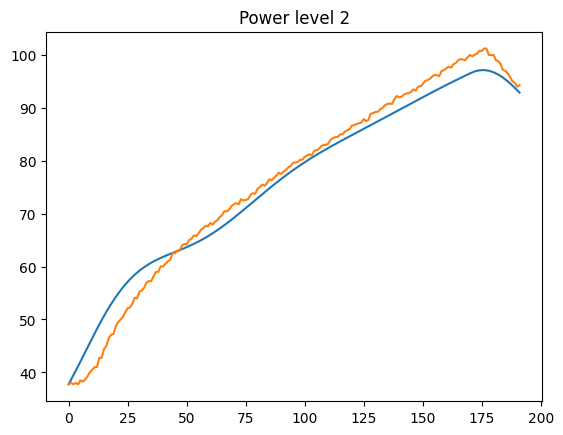

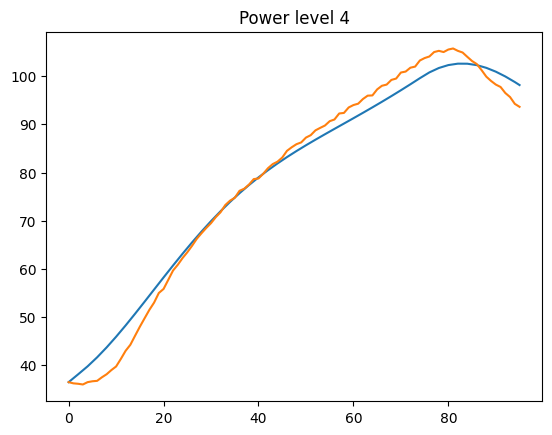

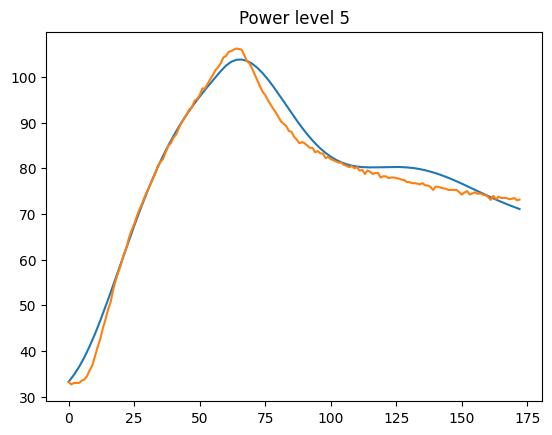

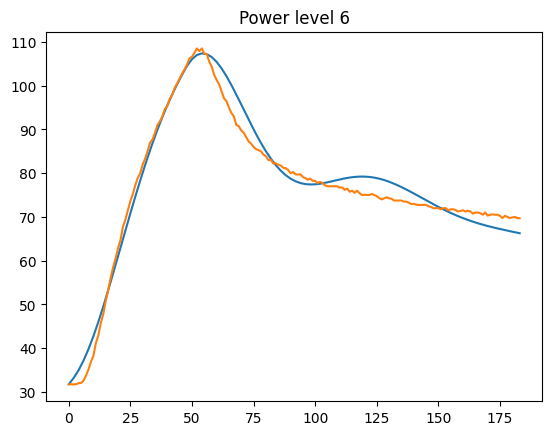

In [13]:
for i in data_torch.keys():
    t = data_torch[i]["t"].detach().numpy()
    T_pred = model(data_torch[i]["t"], data_torch[i]["u"], data_torch[i]["x0"]).detach().numpy()
    T_true = data_torch[i]["T"].detach().numpy()
    plt.plot(t.squeeze(), T_pred[0,:,0], label="predicted")
    plt.plot(t.squeeze(), T_true[0,:,0], label="true")
    plt.title("Power level %d" % i )
    plt.show()

In [33]:
dyn = model.dynamics.dynamics
dT_boiler_dt = [-(dyn.A12.detach().numpy() + dyn.A13.detach().numpy()), dyn.A12.detach().numpy(), dyn.A13.detach().numpy(), dyn.A14.detach().numpy()]
dT_water_dt = [dyn.A21.detach().numpy(), -dyn.A21.detach().numpy(), 0, 0]
dT_air_dt = [dyn.A31.detach().numpy(), 0, -(dyn.A31.detach().numpy() + dyn.C4.detach().numpy()), Tamb * dyn.C4.detach().numpy()]
dP_dt = [0, 0, 0, dyn.A44.detach().numpy()]
A = np.vstack((dT_boiler_dt, dT_water_dt, dT_air_dt, dP_dt))
B = np.array([0, 0, 0, dyn.B4.detach().numpy()])[:, None] * scale
c = np.array([0, 0, -Tamb * dyn.C4.detach().numpy(), 0]) * scale

In [34]:
print(A)
print(B)
print(c)

[[ 0.0439003   0.05154647 -0.09544677  0.02243646]
 [-0.00106195  0.00106195  0.          0.        ]
 [ 0.13070092  0.         -0.09877546 -0.79813628]
 [ 0.          0.          0.         -0.00312374]]
[[0.        ]
 [0.        ]
 [0.        ]
 [5.12164116]]
[0.         0.         0.79813628 0.        ]


AttributeError: 'CustomLinearDynamics' object has no attribute 'A'

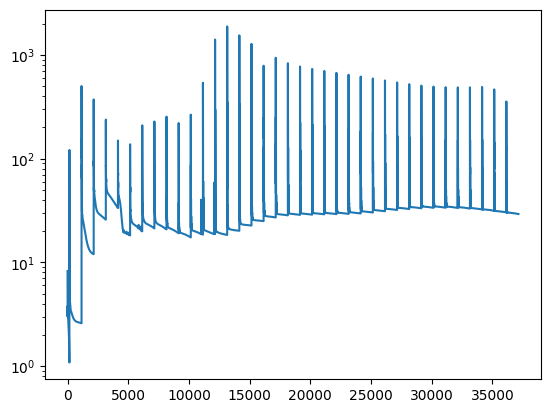

In [28]:
plt.semilogy(losses)
A = model.dynamics.dynamics.A.detach().numpy()
B = model.dynamics.dynamics.B.detach().numpy() * scale
c = model.dynamics.dynamics.c().detach().numpy() * scale

# force Tamb * A@1 + c = 0
c = -Tamb * A@np.ones(n)

print(A)
print(B)
print(c)

In [97]:
B *= scale
c *= scale

In [30]:
x0

array([  0.31750014,  24.00741063, -22.69942392,  78.67178229,
        71.70451603])

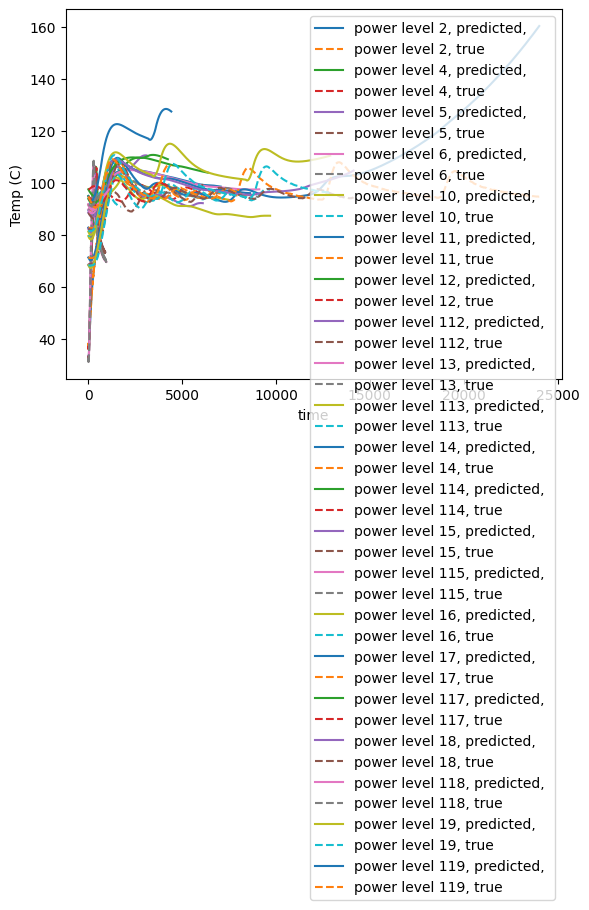

In [32]:
A, B, c = pickle.load(open("temp_dynamics.p", "rb"))

# sanity check
def ddt(x, t, u, tu):
    ut = np.array([np.interp(t, tu, u)])
    return A@x + B @ ut + c.squeeze()

for i in data.keys():
    t, u, T = data[i]["t"], data[i]["u"], data[i]["T"]
    x0 = T[0] * np.ones(n)
    # x0 = trajectories[i].value[:,0]
    x = sp.integrate.odeint(ddt, x0, t, (u, t))

    plt.plot(x[:,0], label="power level %d, predicted, " % i)
    plt.plot(T, "--", label="power level %d, true" % i)

plt.legend()
plt.xlabel("time")
plt.ylabel("Temp (C)")
plt.savefig("temp_model.png")
plt.show()

# # power level 0
# x0 = 30. * np.ones(n)
# x = sp.integrate.odeint(ddt, x0, t, (np.zeros(len(t)), t))
# plt.plot(x[:,0], label="power level %d, predicted, " % 0)
# plt.show()

# # power level i
# i = 1
# x0 = 30. * np.ones(n)
# ui = np.array([i / 6.0 if _t <= 60 and _t > 5 else 0.0 for _t in t])
# x = sp.integrate.odeint(ddt, x0, t, (ui, t))
# plt.plot(x[:,0], label="power level %d, predicted, " % i)
# plt.show()

In [101]:
import pickle
pickle.dump((A,B,c,[trajectories[i].value[:,0] * scale for i in data.keys()]), open("temp_dynamics_scp.p", "wb"))

# dynamics fitting - SCP

In [ ]:
scale = 100
num_states = 5
import pickle
A0, B0, c0 = pickle.load(open("temp_dynamics.p", "rb"))
c0 = c0.reshape(-1, 1)

# A0 = 0.01 * np.eye(num_states)
# B0 = np.ones((num_states, 1))
# c0 = np.random.randn(num_states, 1)

num_hidden = num_states - 1
A = A0
B = B0 / scale
c = c0 / scale

for h in range(25000, 25001, 10):
    print('-'*5 + f'Horizon={h}' + '-'*5)
    for _ in range(10):
        trajectories = {}

        obj = 0.
        constraints = []

        for k in data.keys():
            t, u, T = data[k]["t"].copy(), data[k]["u"].copy(), data[k]["T"].copy()/scale
            t, u, T = t[:h], u[:h], T[:h]
            dt = np.mean(np.ediff1d(t))

            traj = cp.Variable((num_states, len(t)))
            trajectories[k] = traj

            endo = A @ traj[:, :-1] + c
            exo = B @ u[None, :-1]

            obj += cp.sum_squares(traj[0] - T)
            constraints += [
                traj[0, 0] == T[0],
                traj[:, 1:] == traj[:, :-1] + dt * (endo + exo)
            ]
        
        prob = cp.Problem(cp.Minimize(obj), constraints)
        val = prob.solve()
        print(val)

        A_cvx = cp.Variable((num_states, num_states))
        B_cvx = cp.Variable((num_states, 1))
        c_cvx = cp.Variable((num_states, 1))

        obj = cp.norm1(A_cvx) + cp.norm1(B_cvx) + cp.norm1(c_cvx)
        obj += cp.sum_squares(A_cvx) + cp.sum_squares(B_cvx) + cp.sum_squares(c_cvx)
        constraints = []

        for k in data.keys():
            t, u, T = data[k]["t"].copy(), data[k]["u"].copy(), data[k]["T"].copy()/scale
            t, u, T = t[:h], u[:h], T[:h]
            dt = np.mean(np.ediff1d(t))

            traj = trajectories[k].value
            test_traj = cp.Variable((num_states, len(t)))

            endo = A_cvx @ traj[:, :-1] + c_cvx
            exo = B_cvx @ u[None, :-1]

            obj += cp.sum_squares(test_traj[0] - T)
            constraints += [
                test_traj[:, 0] == traj[:, 0],
                test_traj[:, 1:] == test_traj[:, :-1] + dt * (endo + exo)
            ]
        
        prob = cp.Problem(cp.Minimize(obj), constraints)
        prob.solve()

        A = A_cvx.value
        B = B_cvx.value
        c = c_cvx.value

for k in data.keys():
    if k == 11:
        plt.plot(data[k]["t"], trajectories[k].value[0])
        plt.plot(data[k]["t"], data[k]["T"]/scale, '--')